![img](LineMask_get_position.png)

In [27]:
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

from IPython.display import display

def hex_to_bgr(hex_color):
    """
    将十六进制颜色代码转换为 RGB 元组。
    
    参数:
        hex_color (str): 十六进制颜色字符串（如 "#FF0000" 或 "FF0000"）。
    
    返回:
        tuple: (R, G, B)，每个分量范围 0-255。
    
    示例:
        >>> hex_to_rgb("#FF0000")
        (255, 0, 0)
    """
    # 去除可能的 '#' 符号
    hex_color = hex_color.lstrip('#')
    
    # 检查长度是否合法（支持 3 或 6 位十六进制）
    if len(hex_color) == 3:
        hex_color = ''.join([c * 2 for c in hex_color])  # 扩展 "F00" → "FF0000"
    elif len(hex_color) != 6:
        raise ValueError("十六进制颜色代码必须是 3 或 6 位字符（如 '#FF0000' 或 'F00'）")
    
    # 转换为 RGB 整数
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return b,g,r
# observable10 IGV_10
COLORS = [
    hex_to_bgr(i) for i in \
    "#B5CF6B,#E7BA52,#D6616B,#CE6DBD,#9C9EDE,#CEDB9C,#E7CB94,#E7969C,#DE9ED6,#5050FF,#CE3D32,#749B58,#F0E685,#466983,#BA6338,#5DB1DD,#802268,#6BD76B,#D595A7".split(",")
]


In [28]:
class LineMask:
    map_offset = {
        0: -1,
        1: 0,
        2: 1
    }

    def __init__(self, mask, bar_class):
        self.mask = np.load(mask)
        self.bar_class = json.load(open(bar_class))

    def get_position(self, bbox):
        """
        bbox: [x1, y1, x2, y2]
        return: group, measure, staff 
        """
        x1, y1, x2, y2 = list(map(int, bbox))
        bbox_mask = self.mask[y1:y2, x1:x2, :4]
        point = [x1, y1]
        if np.max(bbox_mask) == 0:
            x = int((x2 + x1) / 2)
            y = int((y2 + y1) / 2)
            for i in range(1, 500):
                if self.mask[y-i, x, 0] != 0:
                    y = y - i
                    break
                if self.mask[y+i, x, 0] != 0:
                    y = y + i
                    break
            point = [y, x]
        else:
            point = np.argwhere(bbox_mask[:, :, 0] != 0)[0]
            point[0] = point[0] + y1
            point[1] = point[1] + x1
        return self.mask[point[0], point[1], 0], self.mask[point[0], point[1], 3], self.mask[point[0], point[1], 1]

    def get_pitch_position(self, class_id, bbox):
        """
        class_id: 类别
        bbox: [x1, y1, x2, y2]
        return: group, measure, staff, line, offset

        line  线
            最上方的第五线 为 0
            向下+1
            向上-1

        offset  符头与线的相对位置
            0:线在上，符头在下
            1:线在中间,符头在线中
            2:线在下，符头在上

        """
        x1, y1, x2, y2 = list(map(int, bbox))
        if int(class_id) in [1, 2, 3, 4, 38]:
            y1 = y1 - (y2-y1)/2.5
            y2 = y2 + (y2-y1)/2.5
        elif int(class_id) in [36, 37, 41, 42]:
            y1 = y1 + (y2-y1)/10
            y2 = y2 - (y2-y1)/10
        elif int(class_id) in [35, 39, 40]:
            y1 = y1 + (y2-y1)/3
            y2 = y2 + (y2-y1)/6

        # 沿y轴三等分
        bbox1 = list(map(int, [x1, y1, x2, y1+(y2-y1)/3]))
        bbox2 = list(map(int, [x1, y1+(y2-y1)/3, x2, y1+(y2-y1)*2/3]))
        bbox3 = list(map(int, [x1, y1+(y2-y1)*2/3, x2, y2]))

        bbox_mask1 = self.mask[bbox1[1]:bbox1[3], bbox1[0]:bbox1[2], :4]  # 上位置
        bbox_mask2 = self.mask[bbox2[1]:bbox2[3],
                               bbox2[0]:bbox2[2], :4]  # 中间位置
        bbox_mask3 = self.mask[bbox3[1]:bbox3[3], bbox3[0]:bbox3[2], :4]  # 下位置

        point = list(map(int, [y1, x1]))
        offset = 0
        bbox_mask = self.mask
        if np.max(bbox_mask2) != 0:
            point = np.argwhere(bbox_mask2[:, :, 0] != 0)[0]
            offset = 1
            bbox_mask = bbox_mask2
        elif np.max(bbox_mask1) != 0:
            point = np.argwhere(bbox_mask1[:, :, 0] != 0)[0]
            offset = 0
            bbox_mask = bbox_mask1
        elif np.max(bbox_mask3) != 0:
            point = np.argwhere(bbox_mask3[:, :, 0] != 0)[0]
            offset = 2
            bbox_mask = bbox_mask3
        else:
            position = list(map(int, self.get_position(bbox)))
            print(
                f"error: {point} group: {position[0]}, measure: {position[1]}, staff: {position[2]}")

        return bbox_mask[point[0], point[1], 0], bbox_mask[point[0], point[1], 3], \
            bbox_mask[point[0], point[1],
                      1], bbox_mask[point[0], point[1], 2], offset

    def get_beam_ids(self, bbox):
        """
        bbox: [x1, y1, x2, y2]
        return: beam_ids : []
        0: 表示背景, 只有0表示没有beam
        """
        x1, y1, x2, y2 = list(map(int, bbox))
        # y1 = int(y1 - (y2-y1)/7)
        # y2 = int(y2 + (y2-y1)/7)
        bbox_mask = self.mask[y1:y2, x1:x2, 4]
        beam_ids = np.unique(bbox_mask)
        beam_ids = beam_ids[beam_ids != 0]
        return beam_ids

    def readTxtToYolo(self, txtpath):
        retdata = []
        with open(txtpath, 'r', encoding='utf-8') as f:
            for line in f.readlines():
                line = line.strip().split(' ')
                yolo_box = map(float, line)
                retdata.append(list(yolo_box))
            f.close()
            return np.array(retdata)


LM = LineMask("../mask_int8.npy", "../bar_class.json")

DF_INFO_LABEL = pd.read_csv("info_label.tsv", sep="\t")
LABEL_IDS = {
    "clef": DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("clef"), "label"].to_list(),
    "notehead": DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("notehead"), "label"].to_list(),
    "whole_notehead": DF_INFO_LABEL.loc[
        DF_INFO_LABEL["type"].str.contains(
            "notehead") & DF_INFO_LABEL["type"].str.contains("whole", case=False),
        "label"
    ].to_list(),
    "stem_notehead": DF_INFO_LABEL.loc[
        DF_INFO_LABEL["type"].str.contains(
            "notehead") & ~DF_INFO_LABEL["type"].str.contains("whole", case=False), "label"
    ].to_list(),
    "rest": DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("rest"), "label"].to_list(),
    # 符尾
    "flag": DF_INFO_LABEL.loc[DF_INFO_LABEL["type"].str.contains("flag"), "label"].to_list()
}
print(LABEL_IDS)

# --------------------------------------------------
# duration  相关
# --------------------------------------------------

# key: 符头类型 [-1,7]
#   0表示全音符头，-1表示双全符头, 2^7=128 故7表示一百二十八分符头
# value: 对应类型的duration（divisions为32，以一百二十八分音符为一个单位）
MAP_DURATION = {
    7-i: 1 << i
    for i in range(8+1)
}

# key: rest class_id
# value: key of MAP_DURATION
MAP_REST_TO_DURATION = {k: k-15
                        for k in LABEL_IDS["rest"]
                        }

# key: whole_notehead class_id
# value: key of MAP_DURATION
MAP_WHOLE_NOTEHAD_TO_DURATION = {
    3: 0,
    4: -1
}
# key: flag class_id
# value: key of MAP_DURATION
MAP_FLAG_TO_DURATION = {
    k: k-3
    for k in LABEL_IDS["flag"]
}

# type元素，duration的视觉逻辑
MAP_DURATION_TO_TYPE = {
    1: "128th",
    2: "64th",
    4: "32th",
    8: "16th",
    16: "eighth",
    32: "quarter",
    64: "half",
    128: "whole",
    256: "breve"  # 双全音符
}

{'clef': [12, 13], 'notehead': [1, 2, 3, 4], 'whole_notehead': [3, 4], 'stem_notehead': [1, 2], 'rest': [14, 15, 16, 17, 18, 19, 20, 21, 22], 'flag': [6, 7, 8, 9, 10]}


In [29]:
# --------------------------------------------------
# 音高  相关
# --------------------------------------------------

def pitch_index_parse(index):
    return MAP_PITCH_STEP[index%7],str(index//7)

def get_notehead_soa(line,offset,clef):
    """未处理变音升降"""
    s,a = pitch_index_parse(MAP_CLEF[clef].index - (line*2) + offset)
    return (s,a,"0")


MAP_PITCH_STEP = {k:v
    for k,v in enumerate("CDEFGAB")
}
from collections import namedtuple
CLEF = namedtuple("CLEF","index,sign,line".split(","))
MAP_CLEF = {
    "G":CLEF(5*7+3,"G","2"),
    "F":CLEF(3*7+5,"F","4")
}
print(MAP_CLEF)

{'G': CLEF(index=38, sign='G', line='2'), 'F': CLEF(index=26, sign='F', line='4')}


In [30]:
def show_df(df,n = 2):
    display(df.head(n),df.shape)
def plt_imshow(img):
    plt.close("all")
    with plt.rc_context({
        "figure.dpi":250,
        "xtick.bottom":False,
        "xtick.labelbottom":False,
        "ytick.left":False,
        "ytick.labelleft":False
    }):
        plt.imshow(img[:,:,::-1])
        plt.show()

def create_Element(tag,text=None,attrs=None):
    ele = ET.Element(tag,attrib= attrs if attrs else {})
    if text:
        ele.text = text
    return ele
def assemble_multiple_elements(root,elements):
    """
    将多个元素组装到一个根元素下
    root elements

    root E1

    or
    
    root [E1,E2,E3]

    """
    if isinstance(elements,ET.Element):
        root.append(elements)
    else:
        for i in range(len(elements)):
            if isinstance(elements[i],ET.Element):
                root.append(elements[i])
            else:
                assert i - 1 >= 0 and isinstance(elements[i - 1],ET.Element),\
                    "can not append elements[{}] to elemts[{}]\n\telements[{}] = {}".format(
                        i,i-1,i,elements[i]
                    )
                assemble_multiple_elements(elements[i-1],elements[i])
    return root

def show_obj_attr(obj,func_filter = lambda s: not s.startswith("_")):
    return [ i for i in  dir(obj) if func_filter(i)]


df_label = pd.read_csv("../label_in_image.txt",sep=" ",header = None)
df_label.columns = "class_id,cx,cy,w,h,pos".split(",")
for k in "cx,cy,w,h".split(","):
    df_label[k] = df_label[k].round().astype(np.int64)

df_label["x1"] = df_label.eval("cx - w / 2").round().astype(np.int64)
df_label["y1"] = df_label.eval("cy - h / 2").round().astype(np.int64)
df_label["x2"] = df_label.eval("cx + w / 2").round().astype(np.int64)
df_label["y2"] = df_label.eval("cy + h / 2").round().astype(np.int64)
df_label["row,measure,staff".split(",")] = df_label.apply(lambda row:
               LM.get_position((
                   row["x1"],row["y1"],row["x2"],row["y2"]
                   ))
               ,axis=1).apply(pd.Series)
df_label["line"] = 0
df_label["offset"] = 0

show_df(df_label)

img_source = cv2.imread("../396751092-316810cb-c02d-415b-84bf-408c2e03d914.png")
img_source = cv2.resize(img_source, (2560, 3840))

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
0,12,230,3163,53,161,0.972951,204,3082,256,3244,5,1,1,0,0
1,13,337,906,57,77,0.969918,308,868,366,944,1,1,2,0,0


(803, 15)

# 选择一部分 一个staff

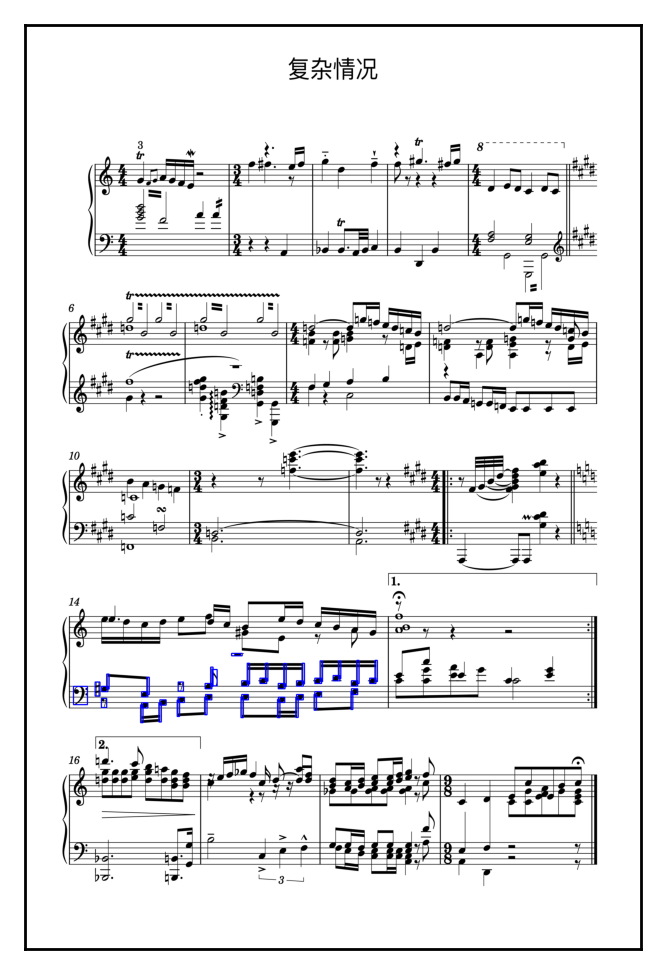

In [31]:
df_label = df_label.query("row == 4 & measure == 1 & staff == 2")
df_label = df_label.sort_values(["cx","cy"]).reset_index(drop=True)

img = img_source.copy()
for row in df_label.itertuples():
    cv2.rectangle(img,(row.x1,row.y1),
                  (row.x2,row.y2),(255,0,0),3)
# plt_imshow(img[2200:2950,:])
plt_imshow(img)

# 符头符杆匹配

有符头不一定有符杆,但有符杆必有符头

而且符头还有共用的情况

符头可以确定音高

**距离**： L1 距离即可，L2距离浪费计算资源

> bad case: 距离最短之前还得过滤

![img](./符头符杆匹配_badcase_01.png)


**尚未考虑多符头的情况(和弦)**

要不然再使用符杆找符头之后

剩下的，尚未分配的符头找各自最近的符杆吧（特别是多符头的情况）

分两步，将所有符头分配给符杆


> 效果还不错

![img](./符头符杆匹配_result.png)


In [32]:
df_stem = df_label.query("class_id == 5").copy()
df_stem["beam_ids"] = df_stem.apply(lambda row:
              LM.get_beam_ids((row["x1"],row["y1"],row["x2"],row["y2"])),
              axis=1)
show_df(df_stem)

df_notehead = df_label[df_label["class_id"].isin(LABEL_IDS["notehead"])].copy()
df_notehead["line,offset".split(",")] = df_notehead.apply(lambda row:
                  LM.get_pitch_position(row.class_id,(row.x1,row.y1,row.x2,row.y2)),
                  axis=1)\
    .apply(pd.Series).iloc[:,3:]
df_notehead["offset"] = df_notehead["offset"].map(
    LM.map_offset)
show_df(df_notehead)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids
4,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62]
5,5,485,2862,10,74,0.843552,480,2825,490,2899,4,1,2,0,0,"[67, 69]"


(20, 16)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
3,1,331,2759,27,23,0.916370,318,2748,344,2770,4,1,2,0,-1
6,1,497,2781,27,23,0.910139,484,2770,510,2792,4,1,2,1,-1


(20, 15)

In [33]:
def find_notehead(df_stem,df_notehead):
    """
    为stem寻找notehead

    分两步：
        1. find_single_notehead_for_stem
            为符杆找符头  适用于1根stem对应一个notehead
        2. find_single_stem_for_notehead
            为剩下的符头找符杆  处理1根stem对应多个notehead
    合并

     df_stem
        新增列 df_stem["notehead_ids"]

    """
    def find_single_notehead_for_stem(x1,y1,x2,y2,df_notehead):
        """
        符杆找符头，一个符杆找一个符头
        
        寻找符杆外侧的最近一个符头
        """
        cx = np.int16(x1+(x2-x1)/2)
        cy = np.int16(y1+(y2-y1)/2)

        # notehead 的上边缘 超出 stem的上边缘
        # notehead 的下边缘 超出 stem的下边缘 
        df_notehead = df_notehead[(y1 > df_notehead["y1"] ) | (y2 <df_notehead["y2"])]
        # | cy - cy | + | cx - cx |
        pesudo_distance = (cx - df_notehead["cx"]).abs() + (cy - df_notehead["cy"]).abs()
        return pesudo_distance.idxmin()

    def find_single_stem_for_notehead(cx,cy,df_stem):
        """
        符头找符杆
        在find_notehead符杆找符头之后
        没有被分配的符头(二分符头和全黑符头)寻找各自的符杆
        即寻找和弦的其他符头

        每个符头找一个符杆
        后于符杆表中汇总
        """
        persudo_distance = (df_stem["cx"] - cx).abs() + (df_stem["cy"] - cy).abs()
        return persudo_distance.idxmin()

    notehead_ids = df_stem.apply(lambda row:find_single_notehead_for_stem(
                        row["x1"],row["y1"],
                        row["x2"],row["y2"],df_notehead),
                        axis=1)

    df_notehead_mutil = df_notehead[
        # 未分配的符头
        ~df_notehead.index.isin(notehead_ids) & \
        # 非 全 符头 （有符杆的）
        df_notehead["class_id"].isin(LABEL_IDS["stem_notehead"])
        ]

    stem_ids = df_notehead_mutil.apply(lambda row:find_single_stem_for_notehead(
        row["cx"],row["cy"],df_stem),axis=1)

    # 汇总
    notehead_ids = notehead_ids.apply(lambda x:[x])
    for i,ids in stem_ids.groupby(stem_ids).apply(lambda df:df.index.to_list()).items():
        notehead_ids.at[i] += ids
    df_stem["notehead_ids"] = notehead_ids

    return df_stem

df_stem = find_notehead(df_stem,df_notehead)
show_df(df_stem)

/tmp/ipykernel_81202/2704913320.py:43: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return persudo_distance.idxmin()


,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids,notehead_ids
4,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62],[3]
5,5,485,2862,10,74,0.843552,480,2825,490,2899,4,1,2,0,0,"[67, 69]",[7]


(20, 17)

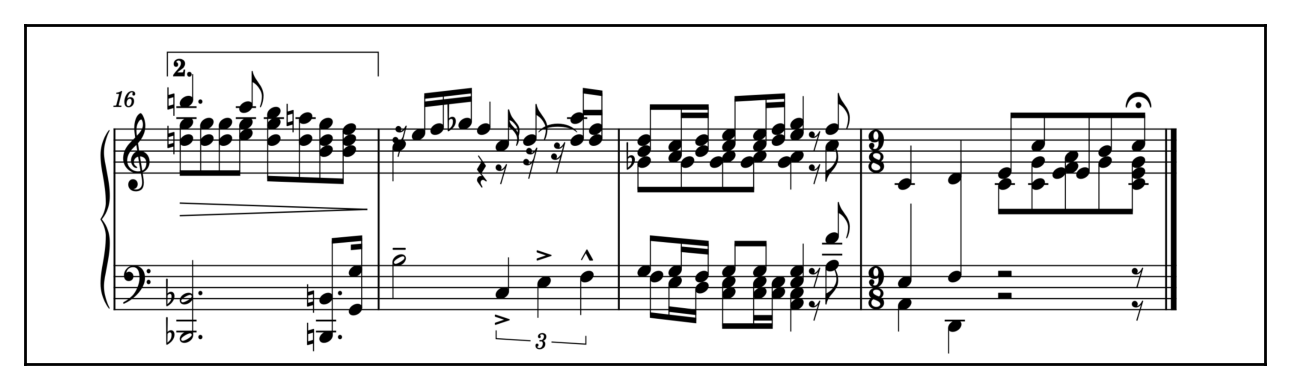

In [34]:
img = img_source.copy()
for row in df_stem.itertuples():
    for i,notehead_id in enumerate(row.notehead_ids):
        cv2.line(img,(row.cx,row.cy),
                (df_notehead.at[notehead_id,"cx"],
                df_notehead.at[notehead_id,"cy"]),
                (0,0,255) if i == 0 else (0,255,0),5)
plt_imshow(img[2900:3600,:])

# 符杆符尾匹配

符尾符梁不是一回事

有符杆不一定有符尾

有符尾肯定有且只有一根符杆

找符尾的符杆，再汇总至符杆

In [35]:
def find_flag(df_stem,df_label):
    """
    为符杆寻找符尾
     df_stem
        新增列 df_stem["flag_id"]
        -1 表示该符杆没有符尾
    """
    df_flag = df_label[df_label["class_id"].isin(LABEL_IDS["flag"])].copy()
    df_flag["stem_id"] = df_flag.apply(lambda row:
        # L1距离最短
        ((row.cx - df_stem["cx"]).abs() + (row.cy - df_stem["cy"]).abs()).idxmin(),
        axis=1
    )
    df_stem["flag_id"] = df_flag["stem_id"].groupby(df_flag["stem_id"]).apply(lambda x:x.index.to_list()[0])
    df_stem["flag_id"] = df_stem["flag_id"].fillna(-1).astype(np.int64)
    return df_stem

df_stem = find_flag(df_stem,df_label)
show_df(df_stem)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids,notehead_ids,flag_id
4,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62],[3],-1
5,5,485,2862,10,74,0.843552,480,2825,490,2899,4,1,2,0,0,"[67, 69]",[7],-1


(20, 18)



>  bad case

一个 八分符尾 受到连线的干扰 存在两个框 

不过这两个框的符杆都是一个，在汇总至符杆表时，仅保留一个即可

不会影响结果

df_label.loc[[309,303],:]

In [36]:
# img = img_source.copy()
# for row in df_flag.itertuples():
#     cv2.rectangle(img,(row.x1,row.y1),(row.x2,row.y2),COLORS[1],5)
#     cv2.putText(img,str(row.Index),(row.x1,row.y1),
#                 cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
#     cv2.rectangle(img,
#         (df_stem.at[row.stem_id,"x1"],df_stem.at[row.stem_id,"y1"]),
#         (df_stem.at[row.stem_id,"x2"],df_stem.at[row.stem_id,"y2"]),
#         COLORS[2],5)
# # plt_imshow(img)
# # plt_imshow(img[400:1150,:])
# # plt_imshow(img[1100:1700,:])
# # plt_imshow(img[1750:2250,:])
# plt_imshow(img[2300:2900,:])
# # plt_imshow(img[2900:3600,:])
# # plt_imshow(img_source[2900:3600,:])

# 获取key_duration

以128分音符的时值为一个DURATION单位

即`<divisions>32</divisions>`

MAP_DURATION 存储了各个音符对应的duration

此处的时值**未考虑附点**

In [37]:
def get_key_duration_for_stem(df_stem,df_notehead):
    """
     df_stem
        新增列 df_stem["key_duration"]
    """
    # 通过符梁数量获取key_duration
    df_stem["key_duration"] = df_stem["beam_ids"].apply(lambda x:len(x)+2)

    # 音符可能单独存在而符梁数为0，通过符尾获取key_duration
    temp_data = df_stem.loc[(df_stem["beam_ids"].apply(len) == 0) & 
                (df_stem["flag_id"] > 0),:]
    key_duration_flag = df_label.loc[temp_data["flag_id"],"class_id"]\
        .map(MAP_FLAG_TO_DURATION).to_frame("key_duration")
    key_duration_flag.index = temp_data.index
    df_stem.update(key_duration_flag)

    # 四分音符和二分音符符梁数均为0，通过符头区分，更新key_duration
    notehead_class_ids  = df_stem.apply(lambda row:
            df_notehead.at[row["notehead_ids"][0],"class_id"],
                axis=1)
    df_stem["key_duration"] = df_stem["key_duration"].mask(
        notehead_class_ids == DF_INFO_LABEL.loc[DF_INFO_LABEL["type"] == "noteheadHalf","label"].iloc[0],
        1 # MAP_DURATION 中 2^1 = 2，故1为二分符头DURATION的key

    )
    return df_stem


df_stem = get_key_duration_for_stem(df_stem,df_notehead)
show_df(df_stem)


,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids,notehead_ids,flag_id,key_duration
4,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62],[3],-1,3
5,5,485,2862,10,74,0.843552,480,2825,490,2899,4,1,2,0,0,"[67, 69]",[7],-1,4


(20, 19)

# 符杆和符梁 联合为 NOTEBLOCK

In [38]:
class BEAM:
    def __init__(self,id,start,end=None):
        self.id = id
        self.start = start
        self.end = end
        self.length = 1 if end is None else 2
    def set_end(self,end):
        if self.end != end:
            self.length += 1
        self.end = end
    def get_beam_content(self,stem_id):
        if stem_id == self.start:
            return "begin"
        if stem_id == self.end:
            return "end"
        return "continue"

    def __repr__(self):
        return "BEAM {} {} ({},{})".format(self.id,self.length,self.start,self.end)

class NOTEBLOCK:
    def __init__(self,stem_id = None,beam_id = None):
        # self.note_ids = [] # 暂不处理
        self.beams = {} # stem_id
        self.stem_ids = set()
        if stem_id:
            self.append_stem(stem_id)
            if beam_id:
                self.append_beam(beam_id,stem_id)
    def __repr__(self):
        return "NOTEBLOCK\n\tstem {stems}\n\tbeams {beams}\n".format(
            stems = ','.join([str(i) for i in self.stem_ids]),
            beams = ','.join([str(i) for i in self.beams.keys()])
            )

    def append_stem(self,stem_id):
        self.stem_ids.add(stem_id)

    def append_beam(self,beam_id,stem_id):
        """
        若beam_id不存在于self.beams
        stem_id作为start    用于创建BEAM
        否则stem_id作为end  用于更新BEAM
        """
        self.append_stem(stem_id)
        if beam_id in self.beams.keys():
            self.beams[beam_id].set_end(stem_id)
        else:
            self.beams[beam_id] = BEAM(beam_id,stem_id)

    def get_box(self,df_label):
        data = df_label.loc[list(self.stem_ids),:]
        return data["x1"].min(),data["y1"].min(),data["x2"].max(),data["y2"].max()
    def get_center_point(self,df_label):
        data = df_label.loc[list(self.stem_ids),:]
        return int(data["x1"].min()+(data["x2"].max()-data["x1"].min())/2),\
                int(data["y1"].min()+(data["y2"].max()-data["y1"].min())/2)
    def get_duration(self,df_label,df_stem):
        assert "key_duration" in df_stem.columns,\
    "there is not a column named 'key_duration' in df_stem, please run 'get_key_duration_for_stem'"
        data = df_stem.loc[list(self.stem_ids),:]
        return data["key_duration"].map(MAP_DURATION).sum()

    def get_beams(self):
        return self.beams
    def get_map_beam_number(self,df_beams):
        df_beams = pd.DataFrame({
            "start":[b.start for b in self.beams.values()],
            "end":[b.end for b in self.beams.values()],
            "length":[b.length for b in self.beams.values()],
        },index=[b.id for b in self.beams.values()])
        df_beams["number"] = 0
        df_beams["state"] = ""
        number_append = 0
        for stem_id in sorted(self.stem_ids):
            # 更新 state
            #   未开始的开始
            #   开始的continue
            rank_mask = df_beams.index.isin(df_stem.at[stem_id,"beam_ids"])
            df_beams.loc[rank_mask & (df_beams["state"] == "start"),"state"] = "continue"
            df_beams.loc[rank_mask & (df_beams["state"] == ""),"state"] = "start"

            # rank仅计算新开始的
            rank_mask = df_beams["state"] == "start"
            rank = df_beams.loc[rank_mask,"length"].rank(ascending=False) + number_append
            df_beams.loc[rank_mask,"number"] = rank.astype(int)
            df_beams.loc[df_beams["end"] == stem_id,"state"] = "end"
            # 记录下一次循环，新开始的beam的number从哪里开始计数
            number_append = df_beams.loc[
                df_beams["state"].isin(["start","continue"]),
                "number"].max()
        return {row.Index : str(int(row.number)) for row in df_beams.itertuples()}


    def to_element(self, df_label, df_stem, df_notehead, clef, staff=1, voice=1):
        list_notes = []
        MAP_BEAM_NUMBER = self.get_map_beam_number(df_stem)

        for stem_id in sorted(self.stem_ids):
            duration = MAP_DURATION[df_stem.at[stem_id, "key_duration"]]
            # 符杆方向
            stem_content = "up" if 0 < df_notehead.at[df_stem.at[stem_id, "notehead_ids"][0],"cy"]\
                  - df_stem.at[stem_id, "cy"] else "down"
            # 符梁组
            #   有顺序要求, 得排序
            #       若begin的beam 在 continue前，osmd不会显示符梁
            list_ele_beam = []
            for beam_id in df_stem.at[stem_id, "beam_ids"]:
                list_ele_beam.append(
                    create_Element("beam",
                                self.beams[beam_id].get_beam_content(stem_id),
                                attrs=dict(number=MAP_BEAM_NUMBER[beam_id])
                                )
                )
            list_ele_beam = sorted(
                list_ele_beam,
                key=lambda s: {"begin": 2, "end": 1, "continue": 0}.setdefault(s.text, 0)
            )
            # 符头组
            for i, notehead_id in enumerate(df_stem.at[stem_id, "notehead_ids"]):
                _s, _o, _a = get_notehead_soa(df_notehead.at[notehead_id, "line"],
                                            df_notehead.at[notehead_id, "offset"], clef)
                ele_note = assemble_multiple_elements(
                    create_Element("note"), [
                        create_Element("pitch"), [
                            create_Element("step", _s),
                            create_Element("octave", _o),
                            create_Element("alter", _a)
                        ],
                        # 声部
                        create_Element("voice", str(voice)),
                        create_Element("staff", str(staff)),
                        # 时值
                        create_Element("duration", str(duration)),
                        create_Element("type", MAP_DURATION_TO_TYPE[duration]),
                    ])
                if i == 0:
                    ele_note = assemble_multiple_elements(
                        ele_note, [
                            create_Element("stem", stem_content),
                            # 符梁
                            *list_ele_beam
                        ])
                else:
                    # 和弦
                    ele_note.append(create_Element("chord"))

                list_notes.append(ele_note)
        return list_notes

    def to_element_pre(self,df_label,df_stem,clef,staff=1,voice=1):
        return [assemble_multiple_elements(
            create_Element("note"),[
                create_Element("pitch"),[
                    create_Element("step","B"),
                    create_Element("octave","4"),
                    create_Element("alter","0")
                ],
                create_Element("duration","32"),
                create_Element("stem","up"),
                create_Element("type","quarter")
            ]
        )]

class NOTEBLOCK_MANAGER:
    """
    管理一个staff 内的 NOTEBLOCK
    """
    flag = "nb"
    def __init__(self):
        # self.map_beam_to_nb = {}
        self.map_beam_to_stem = {} # k 符梁id value 起始符杆id
        self.nbs = {} # k 起始符杆id

    def find_noteblock(self,beam_ids):
        """
        map_beam_to_stem将起始stem一致的beam视为一组
        无法处理下方的bad case

        find_noteblock可处理bad case并返回该组的起始stem
        若无则返回None

        OK 以起始steam为key
        |   |   |
        |---|   |
        |   |   |
        |---|---|

        bad case  短线与长线的起始steam不同
        |   |   |
        |   |---|
        |   |   |
        |---|---|

        """
        for beam_id in beam_ids:
            if beam_id in self.map_beam_to_stem.keys():
                return self.map_beam_to_stem[beam_id]
        return None

    def append(self,stem_id,beam_ids):
        stem_start = self.find_noteblock(beam_ids)
        if stem_start:
            self.map_beam_to_stem.update({beam_id:stem_start for beam_id in beam_ids})
            nb = self.nbs[stem_start]
            for beam_id in beam_ids:
                            nb.append_beam(beam_id,stem_id)
        else:
            self.map_beam_to_stem.update({beam_id:stem_id for beam_id in beam_ids})
            nb = NOTEBLOCK(stem_id)
            for beam_id in beam_ids:
                nb.append_beam(beam_id,stem_id)
            self.nbs[stem_id] = nb
    
    def __repr__(self):
        if len(self.nbs) == 0:
            return "NOTEBLOCK_MANAGER\n\t{}".format("None")
        else:
            return "NOTEBLOCK_MANAGER\n\t{}".format(",".join([str(i) for i in self.nbs.keys()]))
    
    # dict-like
    def keys(self):
        return self.nbs.keys()
    def values(self):
        return self.nbs.values()
    def items(self):
        return self.nbs.items()
    def is_empty(self):
        return 0 == len(self.nbs)
    def __getitem__(self, key):
            return self.nbs[key]
    def __setitem__(self, key, value):
        self.nbs[key] = value
    def __delitem__(self, key):
        del self.nbs[key]

nb_manager = NOTEBLOCK_MANAGER()
for stem_id,row in df_stem.iterrows():
    nb_manager.append(stem_id,row["beam_ids"])

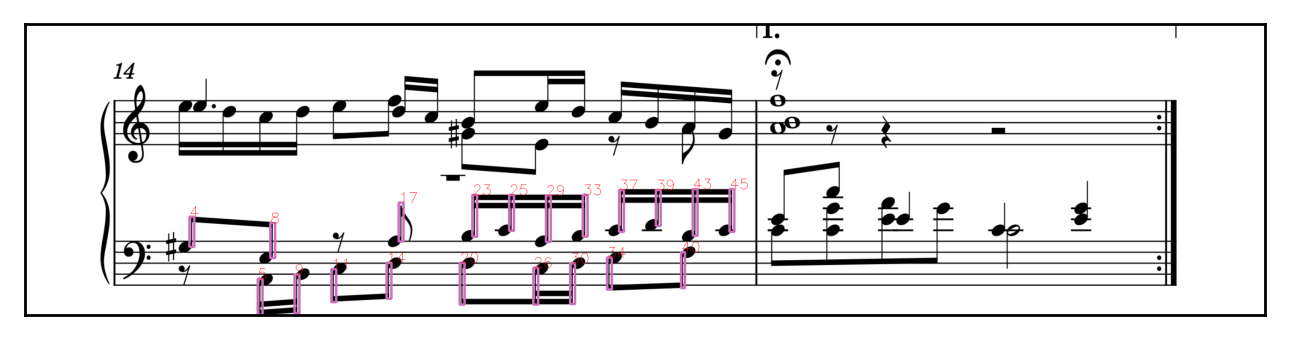

In [39]:
img = img_source.copy()
for i,row in df_stem.iterrows():
    cv2.rectangle(img,
        (row.x1,row.y1),(row.x2,row.y2),COLORS[3],4)
    cv2.putText(img,str(i),(row.x1,row.y1),
                cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
# for i,row in df_notehead.iterrows():
#     row = row.astype(int)
#     cv2.rectangle(img,
#         (row.x1,row.y1),(row.x2,row.y2),COLORS[1],4)
#     cv2.putText(img,str(i),(row.x1,row.y1),
#                 cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))

plt_imshow(img[2300:2900,:])

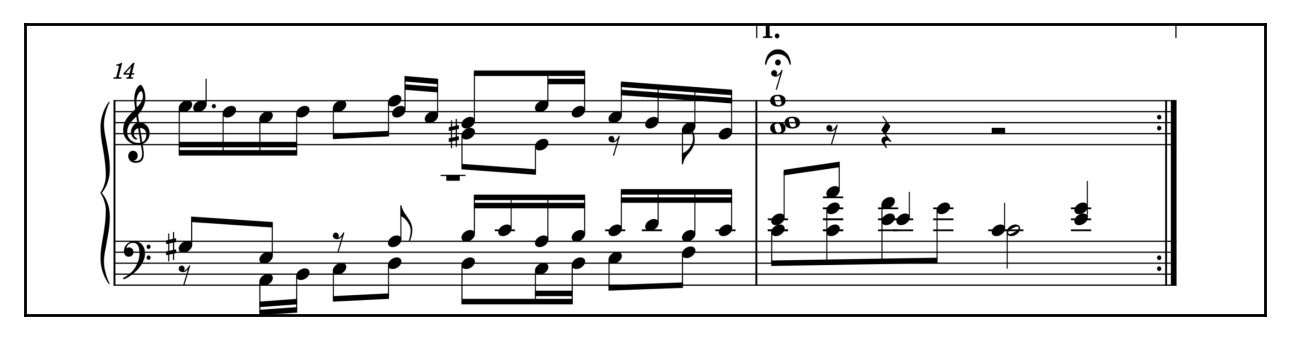

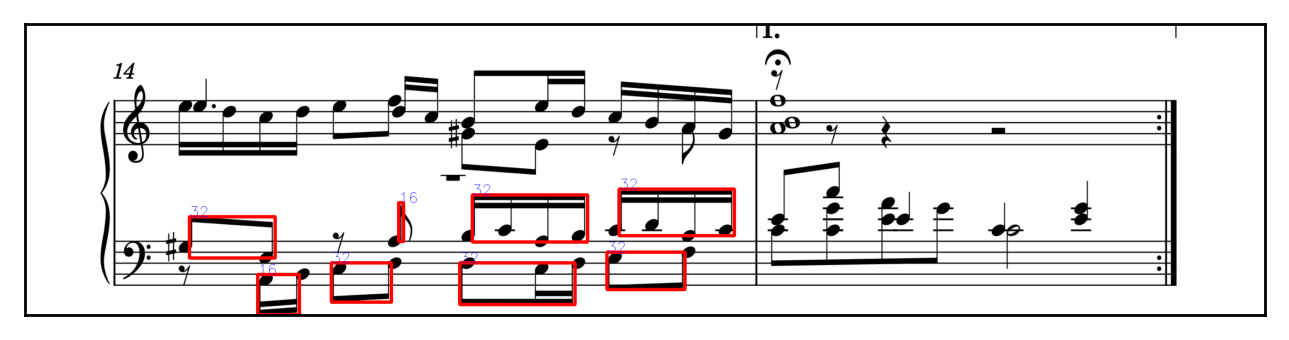

In [40]:
img = img_source.copy()
# print("duration = ",nb.get_duration(df_stem))
for k,nb in nb_manager.items():

    box = nb.get_box(df_label)
    cv2.rectangle(img,box[2:],box[:2],(0,0,255),5)
    cv2.putText(img,str(nb.get_duration(df_label,df_stem)),
                box[:2],cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))

# offset = 100
# plt_imshow(img[box[1]-offset:box[3]+offset,box[0]-offset:box[2]+offset])
plt_imshow(img_source[2300:2900,:])
plt_imshow(img[2300:2900,:])


stem 109 和 115 不是一个符梁？？？？

啊这。。。。。

In [41]:
# show_df(df_stem.loc[[109,115],:])

# img = img_source.copy()
# for row in df_stem.loc[[109,115],:].itertuples():
#     cv2.rectangle(img,
#                   (row.x1,row.y1),
#                   (row.x2,row.y2),
#                   (0,0,255),2)

#     for i in row.notehead_ids:
#         cv2.rectangle(img,
#                 (df_notehead.at[i,"x1"],df_notehead.at[i,"y1"]),
#                 (df_notehead.at[i,"x2"],df_notehead.at[i,"y2"]),
#                 (255,0,0),2)

# plt_imshow(img[500:700,400:600])

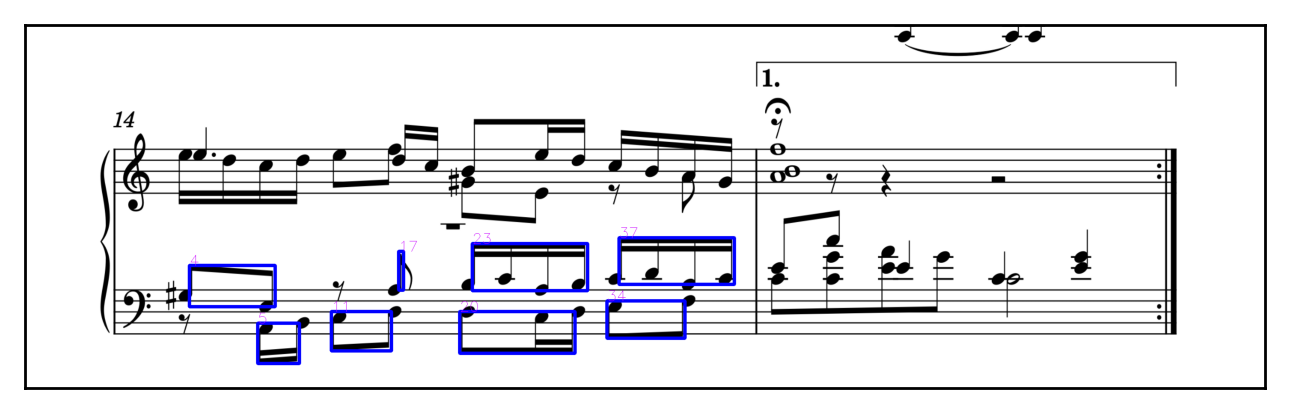

In [42]:
img = img_source.copy()
for i,nb in nb_manager.nbs.items():
    box = nb.get_box(df_label)
    cv2.rectangle(img,box[:2],box[2:],(255,0,0),5)
    cv2.putText(img,str(i),box[:2],
                # cv2.FONT_HERSHEY_SIMPLEX,
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                1,(255,0,200)
                )
plt_imshow(img[2200:2950,:])
# plt_imshow(img)

# 纳入休止符 和 全符头

> 休止符


In [43]:
df_rest = df_label[df_label["class_id"].isin(LABEL_IDS["rest"])]
show_df(df_rest)
class RESTBLOCK:
    def __init__(self,id):
        self.id = id
    def get_box(self,df_label):
        return df_label.at[self.id,"x1"],df_label.at[self.id,"y1"],\
            df_label.at[self.id,"x2"],df_label.at[self.id,"y2"]
    def get_center_point(self,df_label):
        return df_label.at[self.id,"cx"],df_label.at[self.id,"cy"]
    def get_duration(self,df_label,df_stem):
        return MAP_DURATION[MAP_REST_TO_DURATION[
            df_label.at[
                self.id,"class_id"]]]
    def to_element(self,df_label,df_stem,df_notehead,clef,staff=1,voice=1):
        duration = self.get_duration(df_label,df_stem)
        return [assemble_multiple_elements(
            create_Element("note"),[
                create_Element("rest"),
                create_Element("duration",str(duration)),
                create_Element("voice",str(voice)),
                create_Element("staff",str(staff)),
                create_Element("type",MAP_DURATION_TO_TYPE[duration])

            ]
        )]
    def __repr__(self):
        return "RESTBLOCK  {}".format(self.id)

class RESTBLOCK_MANAGER:
    flag = "rb"
    def __init__(self,ids = None):
        self.rbs = {id:RESTBLOCK(id) for id in ids}

    def append(self,id):
        self.rbs[id] = RESTBLOCK(id)

    def __repr__(self):
        if len(self.rbs) == 0:
            return "RESTBLOCK_MANAGER\n\t{}".format("None")
        else:
            return "RESTBLOCK_MANAGER\n\t{}".format(",".join([str(i) for i in self.rbs.keys()]))

    # dict-like
    def keys(self):
        return self.rbs.keys()
    def values(self):
        return self.rbs.values()
    def items(self):
        return self.rbs.items()
    def is_empty(self):
        return 0 == len(self.rbs)
    def __getitem__(self, key):
        return self.rbs[key]
    def __setitem__(self, key, value):
        self.rbs[key] = value
    def __delitem__(self, key):
        del self.rbs[key]

rb_manager = RESTBLOCK_MANAGER(df_rest.index.to_list())
# rb_manager.rbs[4].get_box(df_label)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
2,18,328,2817,22,39,0.897522,317,2798,339,2836,4,1,2,0,0
12,18,647,2749,22,39,0.907963,636,2730,658,2768,4,1,2,0,0


(3, 15)

> 全符头

全音符头和双权符头，没有符杆


In [44]:
class WHOLENOTEHEADBLOCK:
    def __init__(self,id):
        self.id = id
    def get_box(self,df_label):
        return df_label.at[self.id,"x1"],df_label.at[self.id,"y1"],\
            df_label.at[self.id,"x2"],df_label.at[self.id,"y2"]
    def get_center_point(self,df_label):
        return df_label.at[self.id,"cx"],df_label.at[self.id,"cy"]
    def get_duration(self,df_label,df_stem):
        return MAP_DURATION[MAP_WHOLE_NOTEHAD_TO_DURATION[
            df_label.at[
                self.id,"class_id"]]]
    
    def to_element(self,df_label,df_stem,df_notehead,clef,staff=1,voice=1):
        duration = MAP_DURATION[
            MAP_WHOLE_NOTEHAD_TO_DURATION[df_label.at[self.id,"class_id"]]]

        _,_,_,line,offset = LM.get_pitch_position(
            df_label.at[self.id,"class_id"],(
                df_label.at[self.id,"x1"],df_label.at[self.id,"y1"],
                df_label.at[self.id,"x2"],df_label.at[self.id,"y2"]
            )
        )
        offset = LM.map_offset[offset]
        _s,_o,_a = get_notehead_soa(line,offset,clef)
        voice = 1
        staff = 1

        ele_wholenotehead = assemble_multiple_elements(
            create_Element("note"),[
                create_Element("pitch"),[
                    create_Element("step",_s),
                    create_Element("octave",_o),
                    create_Element("alter",_a)
                ],
                create_Element("duration",str(duration)),
                create_Element("type",MAP_DURATION_TO_TYPE[duration]),
                create_Element("voice",str(voice)),
                create_Element("staff",str(staff))
            ]
        )
        return [ele_wholenotehead]

    def __repr__(self):
        return "WHOLENOTEHEAD  {}".format(self.id)

class WHOLENOTEHEAD_MANAGER:
    flag = "wnb"
    def __init__(self,ids = None):
        self.wnbs = {id:WHOLENOTEHEADBLOCK(id) for id in ids}

    def append(self,id):
        self.wnbs[id] = WHOLENOTEHEADBLOCK(id)
    def __repr__(self):
        if len(self.wnbs) == 0:
            return "WHOLENOTEHEAD_MANAGER\n\t{}".format("None")
        else:
            return "WHOLENOTEHEAD_MANAGER\n\t{}".format(",".join([str(i) for i in self.wnbs.keys()]))

    # dict-like
    def keys(self):
        return self.wnbs.keys()
    def values(self):
        return self.wnbs.values()
    def items(self):
        return self.wnbs.items()
    def is_empty(self):
        return 0 == len(self.wnbs)
    def __getitem__(self, key):
            return self.wnbs[key]
    def __setitem__(self, key, value):
        self.wnbs[key] = value
    def __delitem__(self, key):
        del self.wnbs[key]

df_whole =  df_label[df_label["class_id"].isin(LABEL_IDS["whole_notehead"])]

wnh_manager =  WHOLENOTEHEAD_MANAGER(df_whole.index.to_list())
wnh_manager

WHOLENOTEHEAD_MANAGER
	None

In [45]:
show_df(df_stem)
show_df(df_notehead)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset,beam_ids,notehead_ids,flag_id,key_duration
4,5,344,2728,10,62,0.848996,339,2697,349,2759,4,1,2,0,0,[62],[3],-1,3
5,5,485,2862,10,74,0.843552,480,2825,490,2899,4,1,2,0,0,"[67, 69]",[7],-1,4


(20, 19)

,class_id,cx,cy,w,h,pos,x1,y1,x2,y2,row,measure,staff,line,offset
3,1,331,2759,27,23,0.916370,318,2748,344,2770,4,1,2,0,-1
6,1,497,2781,27,23,0.910139,484,2770,510,2792,4,1,2,1,-1


(20, 15)

# musicxml组装

In [46]:
et = ET.parse("musicxml_head.xml")
root = et.getroot()

# dict-like items keys values0
wnh_manager # 全音头 (无符杆)
nb_manager  # 符杆符头块
rb_manager  # 休止符

RESTBLOCK_MANAGER
	2,12,19

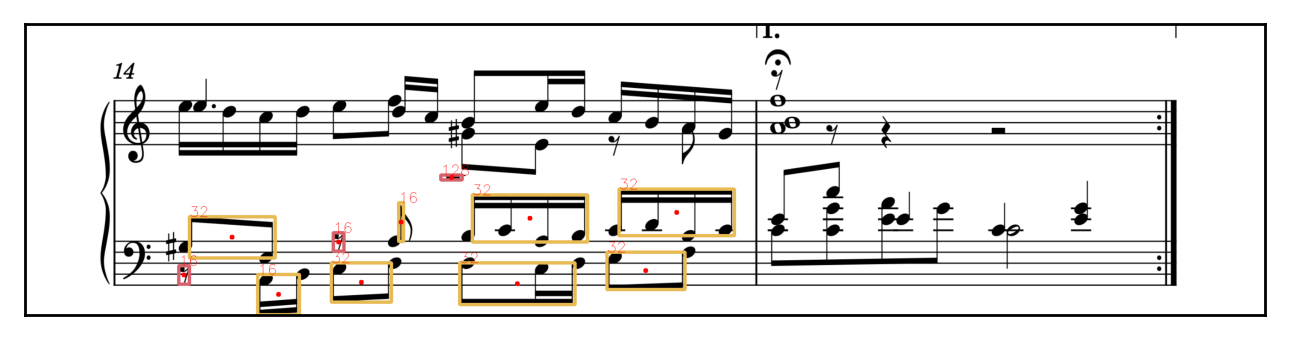

In [47]:
img = img_source.copy()

for color,manager in zip(
    COLORS[1:],
    [nb_manager,rb_manager,wnh_manager]
):

    for i,v in manager.items():
        box = v.get_box(df_label)
        cv2.rectangle(img,box[:2],box[2:],color,5)
        cv2.putText(img,str(v.get_duration(df_label,df_stem)),
                    box[:2],cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255))
        cv2.circle(img,v.get_center_point(df_label),5,(0,0,255),-1)


plt_imshow(img[2300:2900,:])

In [48]:
def is_same_beat_block(
        x11,x12,x21,x22,tolerate = 0
):
    """
    保证x11 < x21
    计算x12 - x21
    情况1和情况2为正数,返回True
    情况3为负数,若可承受,返回True,否则返回False

        x11             x12
        |               |
    1        x21    x22
        |               |
    2        x21             x22
        |               |
    3                        x21    x22
        |               |

    """
    if x11 > x21:
        x11,x21 = x21,x11
        x12,x22 = x22,x12
    return x12 - x21 + tolerate >= 0


In [49]:
class BLOCK_MANAGER:

    def get_df_from_block_manager(self,manager,df_label,df_stem):
        if manager.is_empty():
            return None

        df1 = pd.Series(
            [v.get_box(df_label) for k,v in  manager.items()]
        ).apply(pd.Series)
        df1.columns = "x1,y1,x2,y2".split(",")

        df2 = pd.Series(
            [v.get_center_point(df_label) for k,v in  manager.items()]
        ).apply(pd.Series)
        df2.columns = "cx,cy".split(",")
        df3 = pd.Series(
            [v.get_duration(df_label,df_stem) for k,v in  manager.items()]
        ).apply(pd.Series)
        df3.columns = "duration".split(",")

        return pd.concat([df1,df2,df3],axis=1).assign(
            flag=manager.flag,
            id = manager.keys()
            )
    def get_df_block(self,df_label,df_stem,*managers):
        return pd.concat([ self.get_df_from_block_manager(m,df_label,df_stem) 
            for m in managers if not m.is_empty()],axis=0)\
            .reset_index(drop=True)

    def __init__(self,df_label,df_stem,df_notehead,*managers):
        self.df_label = df_label
        self.df_stem = df_stem
        self.df_notehead = df_notehead
        self.df_block = self.get_df_block(df_label,df_stem,*managers)
        self.manager = {
            m.flag : m
            for m in  managers
        }
bm = BLOCK_MANAGER(df_label,df_stem,df_notehead,rb_manager,wnh_manager,nb_manager)
bm.manager

{'rb': RESTBLOCK_MANAGER
 	2,12,19,
 'wnb': WHOLENOTEHEAD_MANAGER
 	None,
 'nb': NOTEBLOCK_MANAGER
 	4,5,11,17,20,23,34,37}

> voice 未来再想办法

`df_block["voice"]  =  df_block["beat_block_y"]`

> 已知信息

各个box,(cx,cy), duration

notehead

>> x 方向

```python
df_block["beat_block_x"] = 1
counter_beat_block = 1
df_block = df_block.sort_values("x1,y1".split(","))\
    .reset_index(drop=True)
for i in range(len(df_block.index)-1):
    # i , i+1 是否为一个 beat_block
    if is_same_beat_block(
        df_block.at[i,"x1"],
        df_block.at[i,"x2"],
        df_block.at[i+1,"x1"],
        df_block.at[i+1,"x2"],10 # 一个符头越33 px
    ):
        df_block.at[i+1,"beat_block_x"] = df_block.at[i,"beat_block_x"]
    else:
        counter_beat_block += 1
        df_block.at[i+1,"beat_block_x"] = counter_beat_block


display(df_block)

img = img_source.copy()
for i,row in df_block.iterrows():
    cv2.rectangle(img,
        (row.x1,row.y1),(row.x2,row.y2),COLORS[row.beat_block_x],4)
    cv2.putText(img,str(row.beat_block_x),(row.x1,row.y1),
                cv2.FONT_HERSHEY_SIMPLEX,1.8,(0,0,255))
    
# plt_imshow(img[2300:2900,:])
plt_imshow(img[1100:1700,:])
```


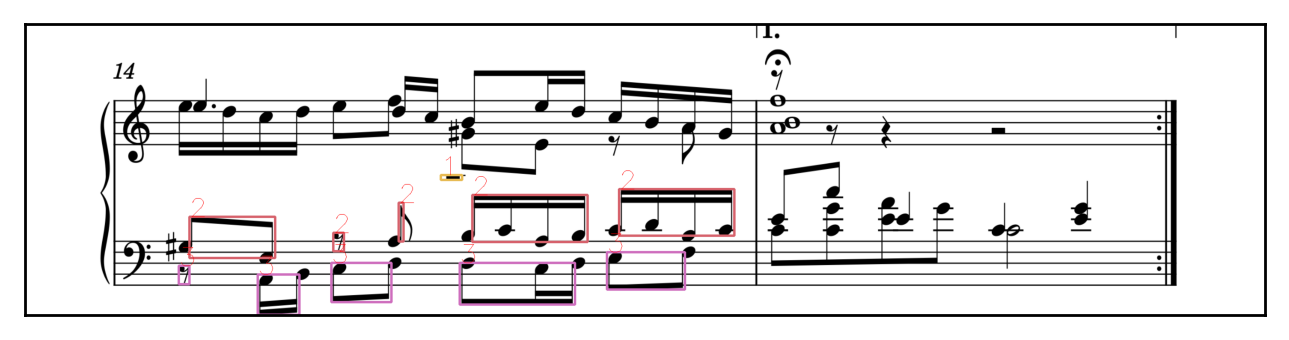

In [50]:
bm.df_block["beat_block_y"] = 1
counter_beat_block = 1
bm.df_block = bm.df_block.sort_values("y1,x1".split(","))\
    .reset_index(drop=True)
for i in range(len(bm.df_block.index)-1):
    # i , i+1 是否为一个 beat_block
    if is_same_beat_block(
        bm.df_block.at[i,"y1"],
        bm.df_block.at[i,"y2"],
        bm.df_block.at[i+1,"y1"],
        bm.df_block.at[i+1,"y2"],0 # 一个符头越33 px
    ):
        bm.df_block.at[i+1,"beat_block_y"] = bm.df_block.at[i,"beat_block_y"]
    else:
        counter_beat_block += 1
        bm.df_block.at[i+1,"beat_block_y"] = counter_beat_block
img = img_source.copy()
for i,row in bm.df_block.iterrows():
    cv2.rectangle(img,
        (row.x1,row.y1),(row.x2,row.y2),COLORS[row.beat_block_y],4)
    cv2.putText(img,str(row.beat_block_y),(row.x1,row.y1),
                cv2.FONT_HERSHEY_SIMPLEX,1.8,(0,0,255))
    
plt_imshow(img[2300:2900,:])
# plt_imshow(img[1100:1700,:])
# plt_imshow(img_source[1100:1700,:])


# show_df(df_block)
# temp = df_block.groupby("beat_block_y")["duration"].sum()

# 应该不会都比MEASUER_DURATION长吧
# 还真有，都在y=1里
# beat_block_y = temp[temp <= MEASUER_DURATION].idxmax()
# beat_block_y



In [51]:
# voice 还得想办法
bm.df_block = bm.df_block.rename(columns={"beat_block_y":"voice"})
# [b.to_element(df_label,df_stem,clef="G") for b in bm.manager["rb"].values()]
# [b.to_element(df_label,df_stem,clef="G") for b in bm.manager["wnb"].values()]
# [b.to_element(df_label,df_stem,clef="G") for b in bm.manager["nb"].values()]

In [52]:
def move_duration(ele_measure,duration,backup_or_forward = "backup"):
    assemble_multiple_elements(
        ele_measure,[
            create_Element(backup_or_forward),[
                create_Element("duration",str(duration))
            ]
        ]
    )
    return ele_measure


clef = "F"

et = ET.ElementTree(create_Element("score-partwise",attrs=dict(version="4.0")))
root = et.getroot()

root = assemble_multiple_elements(root,[
    create_Element("work"),[
        create_Element("work-title","19."),
        create_Element("work-number","BWV Anh. 125")
    ],
    create_Element("part-list"),[
        create_Element("score-part",attrs=dict(id="P1")),[
            create_Element("part-name","part-name")
        ]
    ],
    
])
XML_DECLARATION = """
<!DOCTYPE score-partwise PUBLIC "-//Recordare//DTD MusicXML 4.0 Partwise//EN" "http://www.musicxml.org/dtds/partwise.dtd">
"""
ele_part = create_Element("part",attrs=dict(id="P1"))
assemble_multiple_elements(root,[ele_part])


ele_measure = create_Element("measure",attrs=dict(number="1"))
assemble_multiple_elements(ele_part,[ele_measure])


ele_attr = assemble_multiple_elements(
    create_Element("attributes"), [
        create_Element("divisions", "32"),
        create_Element("key"), [
            create_Element("fifths", "0")
        ],
        create_Element("time"),[
            create_Element("beats","4"),
            create_Element("beat-type","4")
        ],
        create_Element("clef",attrs=dict(number="1")),[
            create_Element("sign",MAP_CLEF[clef].sign),
            create_Element("line",MAP_CLEF[clef].line)
        ]
    ])
assemble_multiple_elements(ele_measure,[ele_attr])


staff = 1
bm.df_block = bm.df_block.sort_values("voice,x1".split(","))
for voice in np.unique(bm.df_block["voice"]):
    # 回退
    if voice > 1:
        move_duration(ele_measure,128)
    for b in bm.df_block[bm.df_block["voice"] == voice].itertuples():
        assemble_multiple_elements(ele_measure,
            bm.manager[b.flag][b.id].to_element(
                bm.df_label,bm.df_stem,bm.df_notehead,clef,staff,voice))


et.write("output.xml",encoding="UTF-8",xml_declaration=XML_DECLARATION)
print("\nfinish\n".center(100,"-"))

----------------------------------------------
finish
----------------------------------------------
